# Heart failure outcome classifier
In this notebook we will take a dive into a [this](https://www.kaggle.com/datasets/asgharalikhan/mortality-rate-heart-patient-pakistan-hospital) dataset of heart failures in Pakistan.  
While I am **not** a medical professional and know only slightly more about heart failures than an average person, I will try to create a model, that will predict the mortality of a heart failure in the Pakistani settings. This model might not work to predict the mortality in other countries, which are more or less medically advanced. 

> **Disclaimer!** This is not a medical study nor recommendation!

## How will it work?
With hypothesis testing, I will determine, which of the features of the patients attribute to the heart failure the most to mortality. Having the best features selected, I will create a model, that will predict the mortality for the given sample of patients. Once the model is created with best possible scores, I will check and determine, which of the features impact mortality the most. 

## How is this model useful?
Knowing the most crucial features that might contribute to fatal heart failure, users of this model might check if in their current health, would they survive a heart failure in Pakistan. In another setting, if the model predicts fatality, whils the user is alive, it might be a suggestion to consult with their doctor the state of their health, to avoid heart failure in the future - this aspect might be useful in any different settings.

## Good to know
Data analized in this study does not touch on the accessability to the hospital or a doctor, time of diagnosis, CPR occurrecne and duration, threatment, how long did it take for the patient to receive firts aid, how far were they from the nearest hospital, chronic diseases, etc. While the dataset gives a good insight on the patients parameters, many life-saving aspects are not included, therefore any conclusions, especially resulting in death on a user of this model should not be taken too seriously. These might however suggest to schedule a check-up with the users doctor.

# Exploratory data analysis

In [77]:
# all imports in one place
import re
import pickle
import statistics as s
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
from ydata_profiling import ProfileReport

import optuna
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# there are many columns, I want to see them all
pd.set_option('display.max_columns', 500)

In [109]:
df = pd.read_csv('data/heart_failure_dataset.csv')

# column names are strangely formated, let's fix them quick
replace_dict = {}

for c in df.columns:
    if c not in replace_dict.keys():
        replace_dict[c] = c.replace(' ', '').replace('.', '')     
                                    
df = df.rename(columns=replace_dict)
df.head()

,Age,AgeGroup,Gender,Locality,Maritalstatus,LifeStyle,Sleep,Category,Depression,Hyperlipi,Smoking,FamilyHistory,FHistory,Diabetes,HTN,Allergies,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,Others,CO,Diagnosis,Hypersensitivity,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,SKReact,Reaction,Mortality,FollowUp
0,45,41-50,Female,RURAL,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,1,NO,NO,100.6,0,84,28.0,0.9,138,3.3,107,130,30,11,9900,4.26,11.6,0.34,79.7,27.2,0.34,265000,0.70,0.25,0.03,2,no,"Chest pain,",EXT. ACUTE WALL M.I,NO,4,132,341,1,2,136,1,3.0,2,0,7,2,1,NO,0,0,60
1,51,51-60,Female,URBAN,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,0,NO,NO,90.6,0,135,17.0,0.7,144,4.7,104,163,30,27,15800,5.74,14.5,0.44,78.0,25.0,0.32,287000,0.73,0.20,0.04,3,no,"Central Chest pain,",A/W M.I,NO,4,130,305,0,0,142,1,1.2,2,0,7,2,1,NO,0,0,15
2,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,100.7,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,LV dysfunction,"Chest pain,SOB, Cold sweating",AC I/W M.I (RV) RE. M.I,NO,4,180,327,0,1,117,1,3.4,2,0,3,2,1,NO,0,0,6
3,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,160.1,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,HTN,"CENTRAL Chest pain,",I/W M.I,NO,4,128,205,0,1,130,1,2.0,2,1,7,3,1,NO,0,0,52
4,56,51-60,Female,RURAL,MARRIED,YES,NO,FREE,YES,YES,NO,NO,0,1,YES,NO,90.6,0,85,78.0,1.2,139,4.5,112,75,18,13,6900,4.41,12.3,0.36,82.0,27.0,0.33,211000,0.71,0.25,0.02,2,no,"Chest pain,",A/W M.I,NO,4,200,288,1,2,133,1,4.0,3,2,7,3,1,NO,0,0,34


In [110]:
df.shape

(368, 60)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               368 non-null    int64  
 1   AgeGroup          368 non-null    object 
 2   Gender            368 non-null    object 
 3   Locality          368 non-null    object 
 4   Maritalstatus     368 non-null    object 
 5   LifeStyle         368 non-null    object 
 6   Sleep             368 non-null    object 
 7   Category          368 non-null    object 
 8   Depression        368 non-null    object 
 9   Hyperlipi         368 non-null    object 
 10  Smoking           368 non-null    object 
 11  FamilyHistory     368 non-null    object 
 12  FHistory          368 non-null    int64  
 13  Diabetes          368 non-null    int64  
 14  HTN               368 non-null    object 
 15  Allergies         368 non-null    object 
 16  BP                368 non-null    float64
 1

In [5]:
df.isna().sum().sum() # there are no NaN values in the dataset

0

In [6]:
# FamilyHistory is the same as FHistory, just not encoded, let's drop it
df = df.drop('FamilyHistory', axis=1)

In [7]:
df.duplicated().sum() # seems there is a lot of duplicates

214

In [8]:
mortality_percentage = df['Mortality'].value_counts(normalize=True) * 100
mortality_percentage

0    78.26087
1    21.73913
Name: Mortality, dtype: float64

Upon further inspection of the dataset, majority of rows are duplicated, which is unfortunate, as this dataset it pretty small.

The differences between the statistics of the dataset with and without the duplicates are similar, and with the duplicates the percentage of patients, who survided the heart failure is larger - this makes the data less unbalanced. 

I wanted to use the duplicates later for training the model. I did the hipothesis testig to check, if the different proportions of 0 and 1 i the `Mortality` would be okay - it would. During the training **however**, any model I used tend to get overfitted and the metrics on the testing subset vere significantly worse, to low for a predictions, where life could be at stake. 

Therefore I will remove the duplicates at this point.

In [112]:
# let's create a copy - a clear dataset
df = df.drop_duplicates()

In [10]:
# let's check the mortality rate in clean dataset
mortality_percentage = df['Mortality'].value_counts(normalize=True) * 100
mortality_percentage

0    82.467532
1    17.532468
Name: Mortality, dtype: float64

In [11]:
df.describe() # now that duplicates are gone, let's see how our data looks

,Age,FHistory,Diabetes,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,Reaction,Mortality,FollowUp
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,55.772727,0.194805,0.409091,118.165779,0.051948,227.948052,47.135714,1.490000,137.987013,4.194805,103.461039,637.694805,69.396104,25.720779,11171.363636,5.115325,13.840260,0.417208,81.033766,27.059740,0.326753,245792.207792,2.294286,0.249026,0.033117,2.214286,3.590909,133.396104,249.448052,0.149351,1.162338,139.993506,0.551948,1.531169,1.818182,1.051948,5.896104,2.032468,0.974026,0.759740,0.175325,28.902597
std,9.036978,0.397343,0.493270,23.459274,0.222646,141.137804,54.496293,3.079576,3.993437,0.369559,4.628885,1085.768192,100.175233,28.377358,3360.261441,0.775705,2.162319,0.065744,7.304875,3.330735,0.027839,78208.509251,11.413506,0.117366,0.015946,0.877938,0.844928,18.592788,49.913133,0.357597,0.980001,22.523915,0.498917,1.300403,0.565391,1.027671,1.715629,1.012464,0.159577,0.428635,0.381485,16.567457
min,24.000000,0.000000,0.000000,80.500000,0.000000,60.000000,2.300000,0.600000,129.000000,3.300000,90.000000,52.000000,14.000000,5.000000,5800.000000,3.460000,9.100000,0.290000,60.000000,18.000000,0.220000,20000.000000,0.360000,0.050000,0.010000,1.000000,1.000000,100.000000,131.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,52.000000,0.000000,0.000000,100.625000,0.000000,127.000000,28.000000,0.800000,135.000000,3.900000,100.000000,131.250000,22.000000,11.000000,7900.000000,4.410000,12.300000,0.360000,78.000000,25.000000,0.320000,187000.000000,0.600000,0.170000,0.020000,2.000000,4.000000,120.000000,213.000000,0.000000,0.000000,125.000000,0.000000,0.225000,1.000000,0.000000,3.750000,1.000000,1.000000,1.000000,0.000000,15.000000
50%,57.000000,0.000000,0.000000,120.700000,0.000000,165.000000,35.500000,0.900000,138.000000,4.200000,104.000000,192.000000,39.000000,16.000000,10400.000000,5.230000,14.100000,0.420000,82.100000,27.800000,0.330000,237000.000000,0.720000,0.210000,0.030000,2.000000,4.000000,130.000000,248.500000,0.000000,2.000000,142.000000,1.000000,1.400000,2.000000,1.000000,7.000000,2.000000,1.000000,1.000000,0.000000,32.000000
75%,61.000000,0.000000,1.000000,130.800000,0.000000,320.000000,42.000000,1.080000,140.750000,4.400000,106.000000,446.000000,52.000000,27.000000,13800.000000,5.650000,15.500000,0.460000,86.000000,29.000000,0.340000,284000.000000,0.797500,0.320000,0.040000,3.000000,4.000000,143.500000,283.000000,0.000000,2.000000,156.750000,1.000000,2.475000,2.000000,2.000000,7.000000,3.000000,1.000000,1.000000,0.000000,36.000000
max,77.000000,1.000000,1.000000,190.110000,1.000000,563.000000,394.000000,22.900000,146.000000,5.300000,112.000000,4289.000000,505.000000,154.000000,19590.000000,6.980000,18.000000,0.540000,96.000000,33.000000,0.390000,459000.000000,83.000000,0.540000,0.080000,5.000000,4.000000,200.000000,409.000000,1.000000,2.000000,195.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000,1.000000,1.000000,60.000000


In [12]:
def outliers(dataframe, column):
    outliers = []
    q1 = np.percentile(sorted(dataframe[column]), 25)
    q3 = np.percentile(sorted(dataframe[column]), 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    for i in sorted(dataframe[column]): 
        if (i < lwr_bound or i > upr_bound):
            outliers.append(i)
    return outliers, lwr_bound, upr_bound

In [13]:
# let's see how do the outliers look
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
outlier_dict = {}

for c in numeric_columns:
    empty = []
    outlier = outliers(df, c)[0]
    if outlier != empty:
        outlier_dict[c] = outliers(df, c), len(outliers(df, c)[0])
        
print(outlier_dict.keys())

dict_keys(['Age', 'FHistory', 'BP', 'Thrombolysis', 'BUrea', 'SCr', 'SPotassium', 'SChloride', 'CPK', 'CKMB', 'ESR', 'MCV', 'MCH', 'MCHC', 'PLATELET_COUNT', 'NEUTROPHIL', 'MONOCYTE', 'EOSINO', 'cp', 'trestbps', 'chol', 'fbs', 'thalach', 'oldpeak', 'SK', 'Reaction', 'Mortality'])


For the rest analysis, I will generate a file using Pandas Profiling, to not prolong this notebook.

In [113]:
profile = ProfileReport(df, title='Heart Failures Profiling')
profile.to_file(output_file='heart_failure_profiling.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

It seems there is a bit of outliers, but this should be examined by a medical professional.
In my unprofessional opinion with help from google, all of those should slide, since these are possible to be observed. Some of these, especially really high or really low values might be correlated with the mortality of the heart failure. Also in some cases, like Mortality, majority of the results is `0`, which suggest the death of the patients, therefore any that are `1`, in other words alive, are the outliers.
## Hypothesis testing
Before we move on with hypothesis testing, it's best to clean up some of the columns in the dataset, so that the messiness does not affect the outcome.

In [15]:
# Feature CO is very messy and all of the patients experience chest pain, so it can be removed
df['CO'] = df['CO'].str.lower() \
                   .str.replace(r'central|chest pain,|day|to|hr|for|from|chest pain', '') \
                   .str.strip()

# and filling in the empty spaces
df['CO'].replace('', 'none', inplace=True)

/var/folders/71/prqs97ps2_lg_s37pr_lsd1h0000gn/T/ipykernel_40469/20299159.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r'central|chest pain,|day|to|hr|for|from|chest pain', '') \


In [16]:
# others column is also messy and requires clean up
df['Others'] = df['Others'].replace(r',\s*|,', ', ', regex=True)

In [17]:
df['SKReact'] = df['SKReact'].str.lower() \
                             .str.strip()

When it comes to `Diagnosis`, I do not understand a letter in here. 
At work, I would ask someone with medical background to group these. Since I am doing this alone, I asked ChatGPT to group these and it distinuished a 5 types:
- myocardial infarctions (MI)
- NSTEMI (Atypical ST elevation during infarction)
- STEMI (ST elevation during infarction)
- other types of heart attacks
- other diagnosis (not cardiac arrest)  

Most of these are cardiac arrests, but in medical aspects are slighly different. 

In [18]:
# Let's group it
for diagnosis in df['Diagnosis'].unique():
    if "M.I" in diagnosis or "ACUTE" in diagnosis:
        # myocardial infarctions (MI)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'MI'
    elif "NSTEMI" in diagnosis:
        # NSTEMI (Atypical ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'NSTEMI'
    elif "STEMI" in diagnosis:
        # STEMI (ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'STEMI'
    elif "CARDIOGENIC" in diagnosis or "MR" in diagnosis or "LBBB" in diagnosis:
        # other diagnosis (not cardiac arrest)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'OTHER'
    else:
        # other types of heart attacks
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'OTHER MI'

### Defining the hipothesis
In this study, I will compare each column, one by one with Mortality, to determine, which of the data could give us more insight, on what really differenciates the individuals who survived their heart failure from those who did not. 

To begin, let's state our hipothesis:

$H_{0}$ = There is no statistically significant difference between Mortality and other column.

$H_{a}$ = There is a statistically significant difference between Mortality and other column.

We will keep only the columns that reject the $H_{0}$, as those are the ones that most significantly affect the Mortality (at least, statistically and within our data). 

In this case, we are interested in a two-tailed tests, since we do not really care if each specific means are greater or lower from each other, but if they are significantly different.

Upon earlier trials and errors, I decided that the significance level should be **0.1**, and therefore the confidence interval will be **90%**. Although in medical data we would rather aim at the greatest possible confidence interval to call a model successful, however this is also not the end of modeling.  

For categorical data, we will conduct a chi-square test, to determine how different the spread is in those cases for mortality, and for numeric columns we will conduct a standard t-test.

In [19]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# numeric columns were already created, but we need to remove the target
numeric_columns.remove('Mortality')

In [20]:
# let's define our chi_square test and t_test for faster processing
def chi_square_test(dataframe, binary_column, categorical_column):
    contingency_table = pd.crosstab(dataframe[binary_column], dataframe[categorical_column])
    hi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    return p_value


def t_test(dataframe, binary_column, numeric_column):
    group0 = dataframe[dataframe[binary_column] == 0][numeric_column]
    group1 = dataframe[dataframe[binary_column] == 1][numeric_column]

    statistic, p_value = ttest_ind(group0, group1)

    return p_value

In [21]:
significant_columns = [] #list of significant columns

alpha = 0.1 # significance level

for column in categorical_columns:
    p_value = chi_square_test(df, 'Mortality', column)
    if p_value <= alpha:
        significant_columns.append(column)

pvalues = []
for column in numeric_columns:
    p_value = t_test(df, 'Mortality', column)
    if p_value <= alpha:
        significant_columns.append(column)
        pvalues.append([column, p_value])

/var/folders/71/prqs97ps2_lg_s37pr_lsd1h0000gn/T/ipykernel_40469/1165978355.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, p_value = ttest_ind(group0, group1)


In [22]:
significant_columns

['AgeGroup',
 'Gender',
 'Smoking',
 'HTN',
 'Others',
 'SKReact',
 'Age',
 'FHistory',
 'Diabetes',
 'WBC',
 'oldpeak',
 'ca',
 'Reaction',
 'FollowUp']

Now with `significant_columns` in mind, we understand, that these features are the most different ones between alive and dead patients (at least - statistically). Our confidence interval in it is 90%.

### Data preparation and encoding
For any further analysis we need to encode all categorical data.

In [23]:
# we cannot miss out target value
significant_columns.append('Mortality')

# since we want the age group to have good encoding, it will be best if we sort by 'Age'
df = df[significant_columns].sort_values(by='Age')

df.head()

,AgeGroup,Gender,Smoking,HTN,Others,SKReact,Age,FHistory,Diabetes,WBC,oldpeak,ca,Reaction,FollowUp,Mortality
25,21-30,Male,NO,NO,no,cough.bleeding,24,0,0,7800,1.6,0,1,5,0
139,21-30,Female,NO,YES,no,no,24,0,1,10900,1.6,0,0,1,0
26,21-30,Male,YES,NO,no,skin.bleeding,25,1,0,6200,0.0,0,1,36,0
140,21-30,Male,YES,NO,PULMONARY ODEMA,no,25,0,0,7600,0.0,0,0,4,0
27,31-40,Male,NO,YES,"IHD, SOB",lungs,35,1,0,12200,3.8,0,1,32,0


In [24]:
binary_columns = ['Smoking', 'HTN']

binary_map = {'NO': 0, 'YES': 1}

label_enc_columns = ['AgeGroup', 'Gender', 'SKReact', 'Others']

In [25]:
# encoding binary columns
df[binary_columns] = df[binary_columns].replace(binary_map)

In [26]:
labeler = LabelEncoder() # here we do not need to define anything inside
labels_dict = {} # for the future reference

for column in label_enc_columns:
    df[column] = labeler.fit_transform(df[column])
    if column not in labels_dict.keys():
        labels_dict[column] = dict(zip(labeler.transform(labeler.classes_), labeler.classes_))
        
with open('data/labeler.pkl', 'wb') as f:
    pickle.dump((labels_dict), f)

In [27]:
# so we keep it originally sorted
df = df.sort_index()
df.head()

,AgeGroup,Gender,Smoking,HTN,Others,SKReact,Age,FHistory,Diabetes,WBC,oldpeak,ca,Reaction,FollowUp,Mortality
0,2,0,0,0,16,4,45,0,1,9900,3.0,0,0,60,0
1,3,0,0,0,16,4,51,0,0,15800,1.2,0,0,15,0
2,3,0,0,1,11,4,55,0,1,7900,3.4,0,0,6,0
3,3,0,0,1,5,4,55,0,1,7900,2.0,1,0,52,0
4,3,0,0,1,16,4,56,0,1,6900,4.0,2,0,34,0


## Principal components analysis

In [28]:
# for PCA we need to scale and center our data
scaler = StandardScaler()

# copying so not to scale all data at once
dff = df.copy() 

# transformation
dff = scaler.fit_transform(dff) 

In [29]:
pca = PCA()
pca.fit(dff)

PCA()

In [30]:
threshold = 0.95

cumulative_var = np.cumsum(pca.explained_variance_ratio_)
cumulative_var

array([0.20962193, 0.3685361 , 0.46969283, 0.55606332, 0.63310657,
       0.69933036, 0.75616887, 0.8093511 , 0.85825972, 0.90093227,
       0.93650735, 0.96308876, 0.98196473, 0.99194766, 1.        ])

In [31]:
components_number = np.argmax(cumulative_var > threshold)
print(f'The number of components explaining {threshold:.0%} of the variance: {components_number}')

The number of components explaining 95% of the variance: 11


In [32]:
print(f'{pca.explained_variance_ratio_[0]:.2%} of the data variance has been preserved along the first principal component,')
print(f'{pca.explained_variance_ratio_[1]:.2%} of the data variance has been preserved along the second principal component, etc.')

20.96% of the data variance has been preserved along the first principal component,
15.89% of the data variance has been preserved along the second principal component, etc.


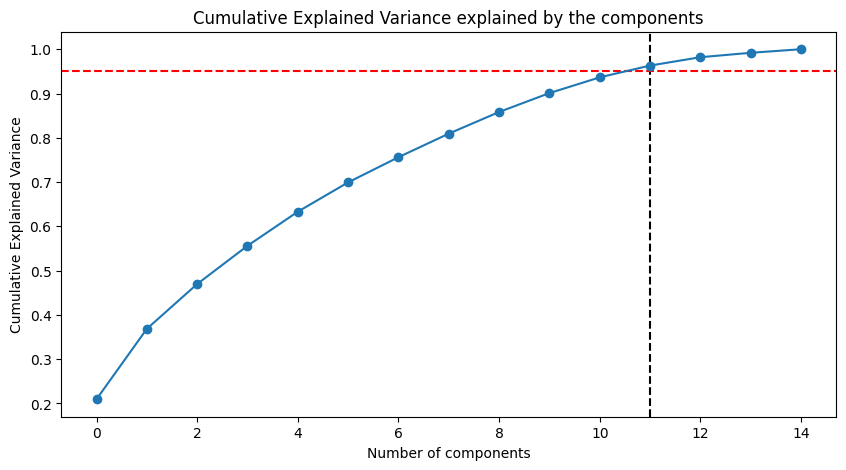

In [33]:
plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of components')
plt.axvline(x=components_number, color="k", linestyle="--")
plt.axhline(y=threshold, color="r", linestyle="--")
plt.plot(cumulative_var, marker='o')
plt.show()

Based on the Principal Components Analysis we can conclude that statistically, we would get should get quite good reluts if we only take 11 features into consideration. 

However, since this dataset is already trimmed by a lot by using hypothesis testing, I will keep all the features when creating our model (or rather concoction of three models) and later decide if it could be trimmed further with feature importances. 

Now with the data splitted into train and test subsets, we can move onto the modeling!

## Model creation
For this modeling I will test three models - RandomForest, XGBoost and CatBoost. All of these are less prone to overfitting and are much better on imbalanced data. 

### Metrics
In evaluating the performance of the model, I will focus on several key metrics, each offering unique insights - accuracy, f1 score and roc score.

**Accuracy** reveals the proportion of accurately classified records. It provides a broad understanding of the model's overall performance.

**F1 score**, on the other hand, combines both precision and recall, offering a balanced assessment of the model's predictive power. It is particularly valuable when dealing with imbalanced datasets - just like the one I am working on.

**ROC score** is another crucial metric. It evaluates the model's ability to distinguish between classes, making it vital for binary classification tasks. As with all these metrics - the higher the better.

By examining these metrics, I can thoroughly evaluate the model's performance and make informed decisions about its effectiveness.

### Other issues
The data set is not evenly distributed, hence I will use `SMOTE` on the training and validating sets, to ensure that both outcome are well represented in training. Of course, the testing data will be only the original from the set.

In [46]:
# firstly let's create some useful functions

def calculate_metrics(target, prediction, average='macro'):
    '''
    With this function we generate all metrics we want to check for classification problem
    '''
    accuracy = accuracy_score(target, prediction)
    f1 = f1_score(target, prediction, average=average)
    roc = roc_auc_score(target, prediction)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, f1, roc, mislabeled, total

def cross_val_metrics(dictionary, target, prediction):
    '''
    This function gathers all most important metrics in a cross validation
    '''
    dictionary['accuracy'].append(accuracy_score(target, prediction))
    dictionary['f1 score'].append(f1_score(target, prediction))
    dictionary['roc score'].append(roc_auc_score(target, prediction))
    mean_accuracy = s.mean(dictionary['accuracy'])
    mean_fscore = s.mean(dictionary['f1 score'])
    mean_roc = s.mean(dictionary['roc score'])
    print(f'Accuracy: {mean_accuracy}, F1 score: {mean_fscore}, ROC: {mean_roc}')
    

def print_results(metrics, classifier_id='classifier'):
    '''
    With this function we are printing all the metrics
    '''
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  F1 score:  {metrics[1]}')
    print(f'  ROC score: {metrics[2]}')
    print(f'  Mislabeled {metrics[3]} out of {metrics[4]}')
    
    
def get_binary_classes(y):
    '''
    With this function we print out the original proporions of 0 and 1 in the subset
    '''
    zeros = len([x for x in y if x == 0])
    ones = len([x for x in y if x == 1])
    print(f'Quantities are {zeros} for 0, {ones} for 1')
    print('\n')
    
def get_confusion_matrix(y, y_pred):
    '''
    This function returns a visualization of a confusion matrix
    '''
    fig, ax = plt.subplots(figsize=(3,3))
    cm = confusion_matrix(y, y_pred)
    ax = sns.heatmap(cm, annot = True, fmt = 'd')
    plt.show()

In [35]:
y = df.pop('Mortality')
X = df

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
                                                   )

# to balance out the data, let's use SMOTE
sm = SMOTE(random_state=42,
           sampling_strategy='auto',
           k_neighbors=4 
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [47]:
kfoldcv = KFold(n_splits=5,
                shuffle=True,
                random_state=42
               )
rfc_vanilla_dict = {'accuracy': [],
                    'f1 score': [],
                    'roc score': []}

# let's try on vanilla RandomForest
for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]
    
    # X_train_scaled = scaler.fit_transform(X_train_fold)
    # X_val_scaled = scaler.fit_transform(X_val_fold)
    
    rfc_vanilla = RandomForestClassifier()
    rfc_vanilla.fit(X_train_fold, y_train_fold)
    y_pred = rfc_vanilla.predict(X_val_fold)
    
    cross_val_metrics(rfc_vanilla_dict, y_val_fold, y_pred)

Accuracy: 0.9024390243902439, F1 score: 0.9259259259259259, ROC: 0.875
Accuracy: 0.9146341463414634, F1 score: 0.9245014245014245, ROC: 0.901614832535885
Accuracy: 0.8930894308943089, F1 score: 0.9020485687152354, ROC: 0.8889553429027113
Accuracy: 0.8948170731707317, F1 score: 0.9015364265364265, ROC: 0.8939892344497608
Accuracy: 0.8808536585365854, F1 score: 0.8853317053317054, ROC: 0.883222078096893


Results for classifier
----
  Accuracy:  0.8387096774193549
  F1 score:  0.7801418439716312
  ROC score: 0.9038461538461539
  Mislabeled 5 out of 31
Quantities are 26 for 0, 5 for 1




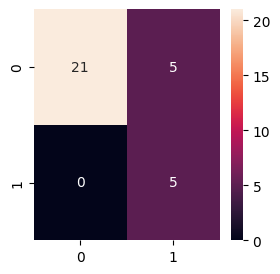

In [48]:
# let's test it on test data, which the model has not seen before
# X_test_scaled = scaler.fit_transform(X_test)
y_test_pred = rfc_vanilla.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred))
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

This vanilla `RandomForest` did quite a good job actually, better than I expected. Also, taking into consideration the results cross validation, it seems that the predictions in all cases are not random and all the average metrics are near 90%, which is not bad.

In the **testing** part, it seem the model recognised well all the patients who survived, but wrongly assigned survival for 5 patients who unfortunately passed. This is the worse outcome, since we give predict the better outcome than the reality.

Now, let's use `OPTUNA`, to see if we can get a better scores with RandomForest.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y 
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',
           k_neighbors=4 # choosing the amount od neighbours, 5 is default
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train_sm, y_train_sm,
                                                      test_size=0.25,
                                                      stratify=y_train_sm
                                                     )

def objective(trial):
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_val_scaled = scaler.fit_transform(X_val)
    

    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
 

    rfc_opt = RandomForestClassifier(max_depth=max_depth, 
                                     n_estimators=n_estimators
                                    )


    rfc_opt.fit(X_train, y_train)
    y_pred_val = rfc_opt.predict(X_val)
    roc = roc_auc_score(y_val, y_pred_val)
    return roc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2023-10-08 20:32:54,011] A new study created in memory with name: no-name-cce60fa9-130d-48b4-a2f0-c4b593ab84f0
[I 2023-10-08 20:32:54,055] Trial 0 finished with value: 0.9199999999999999 and parameters: {'max_depth': 19, 'n_estimators': 49}. Best is trial 0 with value: 0.9199999999999999.
[I 2023-10-08 20:32:54,141] Trial 1 finished with value: 0.8200000000000001 and parameters: {'max_depth': 3, 'n_estimators': 106}. Best is trial 0 with value: 0.9199999999999999.
[I 2023-10-08 20:32:54,267] Trial 2 finished with value: 0.8200000000000001 and parameters: {'max_depth': 2, 'n_estimators': 164}. Best is trial 0 with value: 0.9199999999999999.
[I 2023-10-08 20:32:54,303] Trial 3 finished with value: 0.86 and parameters: {'max_depth': 4, 'n_estimators': 42}. Best is trial 0 with value: 0.9199999999999999.
[I 2023-10-08 20:32:54,412] Trial 4 finished with value: 0.86 and parameters: {'max_depth': 26, 'n_estimators': 135}. Best is trial 0 with value: 0.9199999999999999.
[I 2023-10-08 20:32

In [51]:
best_params = study.best_params
best_params

{'max_depth': 23, 'n_estimators': 108}

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                    random_state=42
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',
           k_neighbors=4,
           random_state=42
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

rfc_dict = {'accuracy': [],
                    'f1 score': [],
                    'roc score': []}

for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]
    
    # X_train_scaled = scaler.fit_transform(X_train_fold)
    # X_val_scaled = scaler.fit_transform(X_val_fold)
    
    best_params = study.best_params
    rfc = RandomForestClassifier(max_depth=best_params['max_depth'], 
                                     n_estimators=best_params['n_estimators']
                                    )   
                              
    rfc.fit(X_train_fold, y_train_fold)
    y_pred = rfc.predict(X_val_fold)
    
    cross_val_metrics(rfc_dict, y_val_fold, y_pred)

Accuracy: 0.9024390243902439, F1 score: 0.9130434782608696, ROC: 0.9
Accuracy: 0.8658536585365854, F1 score: 0.8565217391304348, ROC: 0.8756410256410256
Accuracy: 0.8689024390243902, F1 score: 0.8655881361644759, ROC: 0.8774114774114774
Accuracy: 0.8766768292682927, F1 score: 0.8753815783138331, ROC: 0.883058608058608
Accuracy: 0.8813414634146342, F1 score: 0.8843052626510665, ROC: 0.8877655677655677


Results for Random Forest
----
  Accuracy:  0.9032258064516129
  F1 score:  0.8342245989304813
  ROC score: 0.8615384615384616
  Mislabeled 3 out of 31
Quantities are 26 for 0, 5 for 1




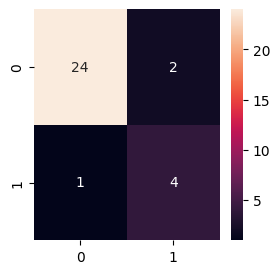

In [80]:
# let's test it on test data, which the model has not seen before
# X_test_scaled = scaler.fit_transform(X_test)
y_test_pred = rfc.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred), classifier_id='Random Forest')
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

models_metrics = {}

models_metrics['Random Forest'] = calculate_metrics(y_test, y_test_pred)

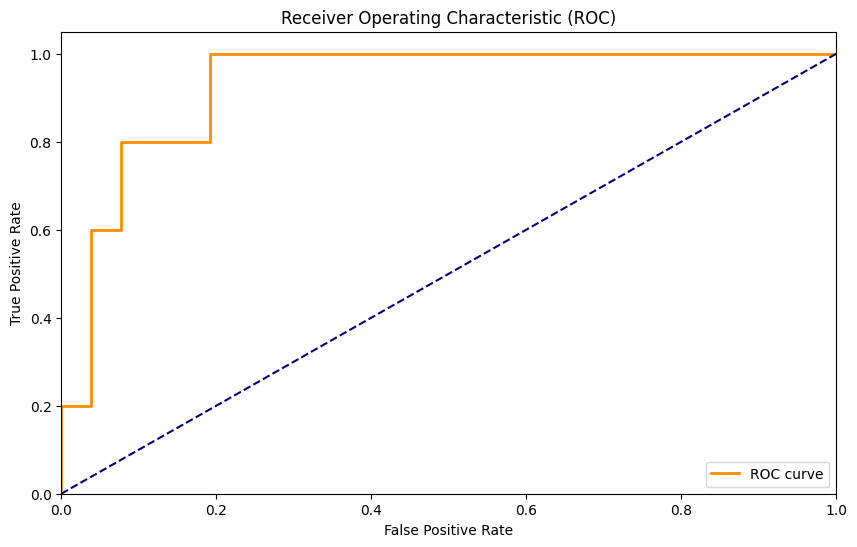

In [78]:
y_probabilities = rfc.predict_proba(X_test)[:, 1] 

fpr, tpr, _ = roc_curve(y_test, y_probabilities)

# ROC curve for RandomForest
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

Upon checking, it seems this time `OPTUNA` didn't help us with creating a much better model - what is good, this time less of the false survivals were generated, which is not the worse outcome as well. 

At the end, I will compare the outcomes of all the models, so we will pick the best one.
Let's also check the feature importances in the instance of Random Forest.

In [57]:
feat_importance_ada = rfc.feature_importances_

# Creating feature importance df
feat_importance_rfc_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feat_importance_ada})
feat_importance_rfc_df = feat_importance_rfc_df.sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(feat_importance_rfc_df)

AdaBoost Feature Importance:
     Feature  Importance
12  Reaction    0.182386
6        Age    0.176981
0   AgeGroup    0.150527
13  FollowUp    0.081668
9        WBC    0.071624
10   oldpeak    0.066461
1     Gender    0.056762
2    Smoking    0.046232
4     Others    0.045365
5    SKReact    0.043307
11        ca    0.041853
8   Diabetes    0.015132
3        HTN    0.011500
7   FHistory    0.010203


RandomForest did well overall, but I would not settle on the first trained model with pretty good outcomes.

Now, let's try with XGBoost, which is also very popular and well fitted for the study problem.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                    random_state=42
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',
           k_neighbors=4,
           random_state=42
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

xgb_vanilla_dict = {'accuracy': [],
                    'f1 score': [],
                    'roc score': []}


for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]

    xgb_vanilla = XGBClassifier()
    xgb_vanilla.fit(X_train_fold, y_train_fold)
    y_pred = xgb_vanilla.predict(X_val_fold)
    
    cross_val_metrics(xgb_vanilla_dict, y_val_fold, y_pred)

Accuracy: 0.9024390243902439, F1 score: 0.8947368421052632, ROC: 0.9070048309178744
Accuracy: 0.8902439024390244, F1 score: 0.886392811296534, ROC: 0.8927881297446515
Accuracy: 0.8768292682926829, F1 score: 0.8807836133281242, ROC: 0.8785254198297676
Accuracy: 0.8763719512195122, F1 score: 0.8815179425542327, ROC: 0.8779597214379823
Accuracy: 0.8910975609756098, F1 score: 0.8956905445195765, ROC: 0.8923677771503858


Results for classifier
----
  Accuracy:  0.8387096774193549
  F1 score:  0.7566718995290425
  ROC score: 0.823076923076923
  Mislabeled 5 out of 31
Quantities are 26 for 0, 5 for 1




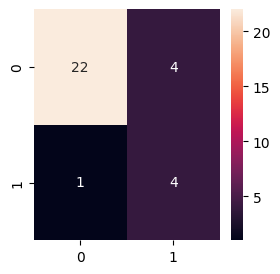

In [82]:
# testing
y_test_pred = xgb_vanilla.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred))
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

When comparing `XGBoost` to `RandomForest`, it worked better on the training sets and slightly worse on the testing set. This might be slight ovefitting the model, but the difference in overal values is not extreme. Not the best model though.

Let's try to optimize it.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                    random_state=42
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',
           k_neighbors=4,
           random_state=42
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train_sm, y_train_sm,
                                                  test_size=0.25,
                                                  stratify=y_train_sm,
                                                  random_state=42
                                                 )

def objective(trial):

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-5, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0)
    }


    xgb_opt = XGBClassifier(**params, random_state=42)

    xgb_opt.fit(X_train, y_train)
    y_pred_val = xgb_opt.predict(X_val)
    roc = roc_auc_score(y_val, y_pred_val)
    return roc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2023-10-08 22:15:14,421] A new study created in memory with name: no-name-e55910be-76a1-4e0f-9be8-e928f61f147c
[I 2023-10-08 22:15:14,660] Trial 0 finished with value: 0.8423076923076922 and parameters: {'booster': 'dart', 'lambda': 0.003025537770321111, 'alpha': 7.990333474110461e-05, 'max_depth': 20, 'eta': 0.12017056951694793, 'gamma': 0.8592394445160404, 'subsample': 0.9368814648161563, 'colsample_bytree': 0.15343772870327718}. Best is trial 0 with value: 0.8423076923076922.
[I 2023-10-08 22:15:14,679] Trial 1 finished with value: 0.7223076923076923 and parameters: {'booster': 'gblinear', 'lambda': 0.00011097289536330961, 'alpha': 0.003875274638598633, 'max_depth': 7, 'eta': 0.29909908409340014, 'gamma': 0.8659890214182511, 'subsample': 0.12138745789797256, 'colsample_bytree': 0.846343156798428}. Best is trial 0 with value: 0.8423076923076922.
[I 2023-10-08 22:15:14,710] Trial 2 finished with value: 0.7446153846153846 and parameters: {'booster': 'gbtree', 'lambda': 0.37247774554

[22:15:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.

[22:15:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.

[22:15:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.



[I 2023-10-08 22:15:15,167] Trial 7 finished with value: 0.8038461538461539 and parameters: {'booster': 'dart', 'lambda': 0.14447286172718085, 'alpha': 1.6980759400639435e-05, 'max_depth': 8, 'eta': 0.06978866567706314, 'gamma': 0.9258211451772068, 'subsample': 0.19828428209784157, 'colsample_bytree': 0.8402100786959706}. Best is trial 0 with value: 0.8423076923076922.
[I 2023-10-08 22:15:15,242] Trial 8 finished with value: 0.8623076923076922 and parameters: {'booster': 'gbtree', 'lambda': 1.8343473834731943e-05, 'alpha': 5.947066013643422e-05, 'max_depth': 8, 'eta': 0.106254902557136, 'gamma': 0.348064939827883, 'subsample': 0.6301516690832094, 'colsample_bytree': 0.5058611357023342}. Best is trial 8 with value: 0.8623076923076922.
[I 2023-10-08 22:15:15,498] Trial 9 finished with value: 0.7838461538461539 and parameters: {'booster': 'dart', 'lambda': 0.003026277655402616, 'alpha': 7.61289077147047, 'max_depth': 13, 'eta': 0.03187979056320864, 'gamma': 0.9238377000030435, 'subsample'

[22:15:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.



[I 2023-10-08 22:15:16,671] Trial 19 finished with value: 0.8823076923076922 and parameters: {'booster': 'dart', 'lambda': 5.4172492893732105e-05, 'alpha': 0.020947820092002575, 'max_depth': 5, 'eta': 0.06554629275884306, 'gamma': 0.1994227275959453, 'subsample': 0.5242389387776456, 'colsample_bytree': 0.941933468590065}. Best is trial 12 with value: 0.9023076923076923.
[I 2023-10-08 22:15:16,749] Trial 20 finished with value: 0.823076923076923 and parameters: {'booster': 'gbtree', 'lambda': 0.0010440546188951506, 'alpha': 0.00012522822936657992, 'max_depth': 13, 'eta': 0.09576035521373691, 'gamma': 0.0013708160083907548, 'subsample': 0.3295535524862162, 'colsample_bytree': 0.7052558027557292}. Best is trial 12 with value: 0.9023076923076923.
[I 2023-10-08 22:15:17,119] Trial 21 finished with value: 0.8430769230769231 and parameters: {'booster': 'dart', 'lambda': 4.720886448166318e-05, 'alpha': 0.02642708976359977, 'max_depth': 5, 'eta': 0.06314792290849362, 'gamma': 0.1593333581659964

[22:15:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.



[I 2023-10-08 22:15:21,149] Trial 35 finished with value: 0.9015384615384615 and parameters: {'booster': 'dart', 'lambda': 0.010828862143407872, 'alpha': 0.004723141356751496, 'max_depth': 7, 'eta': 0.1705523453468562, 'gamma': 0.29285070591082196, 'subsample': 0.5741901330291717, 'colsample_bytree': 0.8352680650113201}. Best is trial 12 with value: 0.9023076923076923.
[I 2023-10-08 22:15:21,215] Trial 36 finished with value: 0.7230769230769232 and parameters: {'booster': 'gblinear', 'lambda': 2.3297326737456983e-05, 'alpha': 0.014756607704644712, 'max_depth': 11, 'eta': 0.09896711245445126, 'gamma': 0.20841946324810057, 'subsample': 0.7597571450884996, 'colsample_bytree': 0.7099808632669955}. Best is trial 12 with value: 0.9023076923076923.


[22:15:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.



[I 2023-10-08 22:15:21,606] Trial 37 finished with value: 0.9215384615384615 and parameters: {'booster': 'dart', 'lambda': 0.00010842428416010336, 'alpha': 0.06070554841161349, 'max_depth': 9, 'eta': 0.14135311778012288, 'gamma': 0.05111187297815902, 'subsample': 0.6717542379292349, 'colsample_bytree': 0.9267493684594311}. Best is trial 37 with value: 0.9215384615384615.
[I 2023-10-08 22:15:21,892] Trial 38 finished with value: 0.9015384615384615 and parameters: {'booster': 'dart', 'lambda': 9.667291453242722e-05, 'alpha': 0.05362047984071164, 'max_depth': 9, 'eta': 0.15892746597997284, 'gamma': 0.062028891500302566, 'subsample': 0.6661995127771101, 'colsample_bytree': 0.9019453443073229}. Best is trial 37 with value: 0.9215384615384615.
[I 2023-10-08 22:15:21,947] Trial 39 finished with value: 0.7223076923076923 and parameters: {'booster': 'gblinear', 'lambda': 3.784930837983945e-05, 'alpha': 0.0029729710831323526, 'max_depth': 12, 'eta': 0.14143444252831294, 'gamma': 0.04734856522636

[22:15:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.



In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                    random_state=42
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',
           k_neighbors=4,
           random_state=42
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

    
xgb_dict = {'accuracy': [],
                    'f1 score': [],
                    'roc score': []}

for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]
    
    best_params = study.best_params


    xgb = XGBClassifier(
        booster=best_params['booster'],
        alpha=best_params['alpha'],
        max_depth=best_params['max_depth'],
        eta=best_params['eta'],
        gamma=best_params['gamma'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )


    xgb.fit(X_train_fold, y_train_fold)
    y_pred = xgb.predict(X_val_fold)


    cross_val_metrics(xgb_dict, y_val_fold, y_pred)

Accuracy: 0.9024390243902439, F1 score: 0.9, ROC: 0.9130434782608696
Accuracy: 0.8780487804878049, F1 score: 0.875, ROC: 0.8940217391304348
Accuracy: 0.8936991869918699, F1 score: 0.8934108527131783, ROC: 0.9049370516761821
Accuracy: 0.8890243902439025, F1 score: 0.8895703346568349, ROC: 0.8983143175791917
Accuracy: 0.886219512195122, F1 score: 0.8912481044601618, ROC: 0.89331812073002


Results for classifier
----
  Accuracy:  0.8387096774193549
  F1 score:  0.7566718995290425
  ROC score: 0.823076923076923
  Mislabeled 5 out of 31
Quantities are 26 for 0, 5 for 1




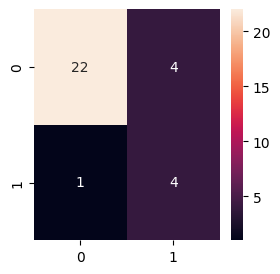

In [87]:
# testing
y_test_pred = xgb.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred))
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

models_metrics['XGBoost'] = calculate_metrics(y_test, y_test_pred)

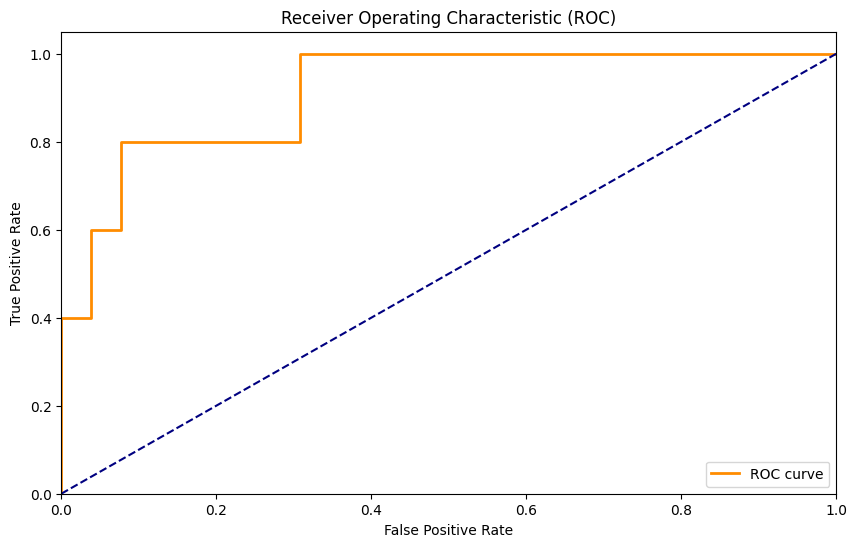

In [86]:
y_probabilities = xgb.predict_proba(X_test)[:, 1] 

fpr, tpr, _ = roc_curve(y_test, y_probabilities)

# ROC curve for RandomForest
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

With the metrics in XGBoost we can conclude, that it worked worse than Random Forest. ROC curve also seems less curvy, which is not good. 

To keep the concept, I will check features importances, but at this point, Random Forest wins.

In [88]:
feat_importance_xgb = xgb.feature_importances_

# Tworzenie DataFrame z ważnością cech
feat_importance_xgb_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feat_importance_xgb})
feat_importance_xgb_df = feat_importance_xgb_df.sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance:")
print(feat_importance_xgb_df)

XGBoost Feature Importance:
     Feature  Importance
12  Reaction    0.242413
1     Gender    0.182482
0   AgeGroup    0.169006
6        Age    0.090916
8   Diabetes    0.047545
2    Smoking    0.045646
10   oldpeak    0.042106
5    SKReact    0.039568
4     Others    0.036168
9        WBC    0.032983
13  FollowUp    0.032555
3        HTN    0.022368
11        ca    0.016245
7   FHistory    0.000000


The last model I will train is `CatBoost`. As per usuall, let's begin with a vanilla case.

In [89]:
from catboost import CatBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                    random_state=42
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',
           k_neighbors=4,
           random_state=42
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

cat_vanilla_dict = {'accuracy': [],
                    'f1 score': [],
                    'roc score': []}

# let's try on vanilla AdaBoost
for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]
    
    # X_train_scaled = scaler.fit_transform(X_train_fold)
    # X_val_scaled = scaler.fit_transform(X_val_fold)
    
    cat_vanilla = CatBoostClassifier(verbose=False)
    cat_vanilla.fit(X_train_fold, y_train_fold)
    y_pred = cat_vanilla.predict(X_val_fold)
    
    cross_val_metrics(cat_vanilla_dict, y_val_fold, y_pred)

Accuracy: 0.9512195121951219, F1 score: 0.9500000000000001, ROC: 0.9511904761904761
Accuracy: 0.9512195121951219, F1 score: 0.9541666666666667, ROC: 0.9478174603174603
Accuracy: 0.9591463414634146, F1 score: 0.9604354354354355, ROC: 0.9576358826358826
Accuracy: 0.938109756097561, F1 score: 0.9412568091347162, ROC: 0.936976911976912
Accuracy: 0.9054878048780488, F1 score: 0.9147075749673474, ROC: 0.9045815295815296


Results for classifier
----
  Accuracy:  0.8387096774193549
  F1 score:  0.7801418439716312
  ROC score: 0.9038461538461539
  Mislabeled 5 out of 31
Quantities are 26 for 0, 5 for 1




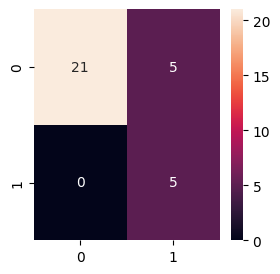

In [90]:
# testing
y_test_pred = cat_vanilla.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred))
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

Overall, metrics for `CatBoost` are slightly better than for `Random Forest`, but in the testing the confusion matrix looks the same - the model predicts too many False Negatives (in this context, these would rather be false positives, pun intendet). It works better than `XGBoost`, so I am hopefull.

Let's move to optimization.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                    random_state=42
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',
           k_neighbors=4,
           random_state=42
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train_sm, y_train_sm,
                                                  test_size=0.25,
                                                  stratify=y_train_sm,
                                                  random_state=42
                                                 )

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'iterations': trial.suggest_int('iterations', 50, 200),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-6, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'random_strength': trial.suggest_float('random_strength', 0.0, 100.0)
    }

    # Tworzenie klasyfikatora z proponowanymi hiperparametrami
    cat_opt = CatBoostClassifier(verbose=0, random_state=42, **params)

    cat_opt.fit(X_train, y_train)
    y_pred_val = cat_opt.predict(X_val)
    roc = roc_auc_score(y_val, y_pred_val)
    return roc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2023-10-08 22:22:33,748] A new study created in memory with name: no-name-92e15d26-088f-4f23-ad1a-478efcc64697
[I 2023-10-08 22:22:33,795] Trial 0 finished with value: 0.8830769230769231 and parameters: {'learning_rate': 0.058920104293831134, 'depth': 7, 'iterations': 73, 'l2_leaf_reg': 1.6708961379622584, 'bagging_temperature': 0.7098680686119829, 'border_count': 142, 'random_strength': 40.796687717754686}. Best is trial 0 with value: 0.8830769230769231.
[I 2023-10-08 22:22:33,827] Trial 1 finished with value: 0.8630769230769231 and parameters: {'learning_rate': 0.06789227985477822, 'depth': 5, 'iterations': 94, 'l2_leaf_reg': 4.587868123847325e-05, 'bagging_temperature': 0.8130962247178382, 'border_count': 165, 'random_strength': 18.847087310120536}. Best is trial 0 with value: 0.8830769230769231.
[I 2023-10-08 22:22:33,866] Trial 2 finished with value: 0.9023076923076923 and parameters: {'learning_rate': 0.21930206900807214, 'depth': 5, 'iterations': 121, 'l2_leaf_reg': 0.0031200

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                    random_state=42
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',
           k_neighbors=4,
           random_state=42
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

    
cat_dict = {'accuracy': [],
                    'f1 score': [],
                    'roc score': []}

for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]
    
    best_params = study.best_params


    cat = CatBoostClassifier(
        learning_rate=best_params['learning_rate'],
        depth=best_params['depth'],
        iterations=best_params['iterations'],
        l2_leaf_reg=best_params['l2_leaf_reg'],
        bagging_temperature=best_params['bagging_temperature'],
        border_count=best_params['border_count'],
        random_strength=best_params['random_strength'],
        verbose=False
    )


    cat.fit(X_train_fold, y_train_fold)
    y_pred = cat.predict(X_val_fold)


    cross_val_metrics(cat_dict, y_val_fold, y_pred)

Accuracy: 0.8780487804878049, F1 score: 0.888888888888889, ROC: 0.8809523809523809
Accuracy: 0.8658536585365854, F1 score: 0.873015873015873, ROC: 0.8678571428571429
Accuracy: 0.8522357723577235, F1 score: 0.8610803494524425, ROC: 0.8535714285714285
Accuracy: 0.8766768292682927, F1 score: 0.881921373200443, ROC: 0.8793090062111801
Accuracy: 0.8863414634146342, F1 score: 0.8927711411135458, ROC: 0.8888638716356108


Results for classifier
----
  Accuracy:  0.9354838709677419
  F1 score:  0.8966666666666667
  ROC score: 0.9615384615384616
  Mislabeled 2 out of 31
Quantities are 26 for 0, 5 for 1




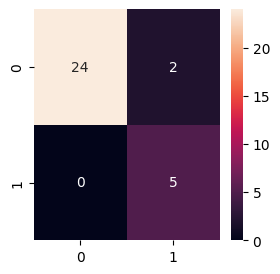

In [94]:
# testing
y_test_pred = cat.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred))
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)
models_metrics['CatBoost'] = calculate_metrics(y_test, y_test_pred)

Okay, it seems that `CatBoost` has the best outcome overall. I will compare it later, but it already looks like it fits best on the testing set.

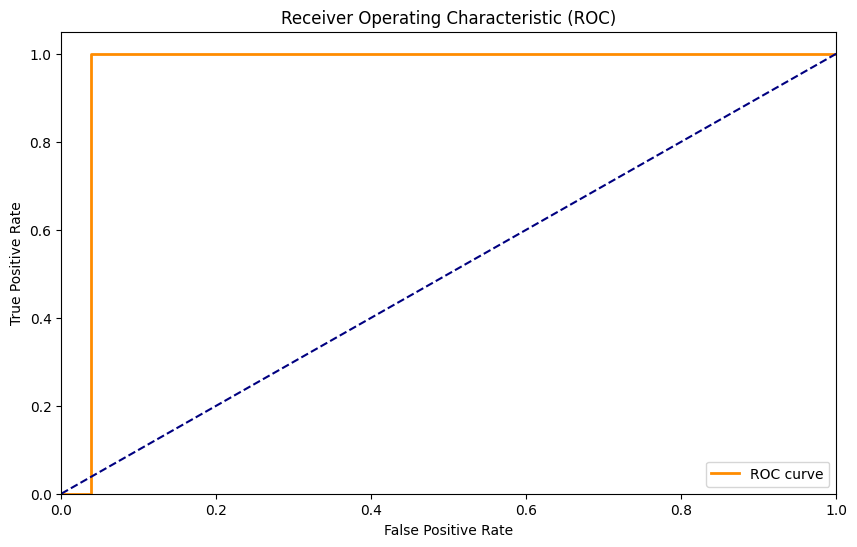

In [97]:
y_probabilities = cat.predict_proba(X_test)[:, 1] 

fpr, tpr, _ = roc_curve(y_test, y_probabilities)

# ROC curve for RandomForest
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [98]:
feat_importance_cat = cat.feature_importances_

# Tworzenie DataFrame z ważnością cech
feat_importance_cat_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feat_importance_xgb})
feat_importance_cat_df = feat_importance_cat_df.sort_values(by='Importance', ascending=False)

print("CatBoost Feature Importance:")
print(feat_importance_cat_df)

CatBoost Feature Importance:
     Feature  Importance
12  Reaction    0.242413
1     Gender    0.182482
0   AgeGroup    0.169006
6        Age    0.090916
8   Diabetes    0.047545
2    Smoking    0.045646
10   oldpeak    0.042106
5    SKReact    0.039568
4     Others    0.036168
9        WBC    0.032983
13  FollowUp    0.032555
3        HTN    0.022368
11        ca    0.016245
7   FHistory    0.000000


# Model choice
For this part, we will compare all the model we tried. I am taking into consideration all the optimized models and comparing the accuracy, f1 score and roc score.

In [105]:
models_metrics.items()

dict_items([('Random Forest', (0.9032258064516129, 0.8342245989304813, 0.8615384615384616, 3, 31)), ('XGBoost', (0.8387096774193549, 0.7566718995290425, 0.823076923076923, 5, 31)), ('CatBoost', (0.9354838709677419, 0.8966666666666667, 0.9615384615384616, 2, 31))])

As per many, **many** iteration and different random states used in training the models, the best one is `CatBoost`. It's our winner!

With the best metrics overall and most of the most labels correctly recognized, `CatBoost` will work best for this dataset. We can now pickle it and put into use.

**Note!**   
As mentioned at the begining - I am not a medical profesionall. If I was creating such a model to be used in real life, on real people, I would definitely work on it with a doctor, cardiologist at best. Perhaps the parameters used would not be optimal to be used at hospitals, maybe different data would be needed or easier available.   
Also, I would ask for more data, so the model could be more better and use the most important (in medical perspective) parameters. As well as for the number of patients to train and test this on, and the features, such as maybe time of cpr, weight of the patient or provided threatment. 

Overall, I am happy with the result of this study and besides the medical factor (which would be crucial in real life study!) the model is destined to work very well.

In [ ]:
with open('data/model.pkl', 'wb') as f:
    pickle.dump((cat), f)

![heart](https://health.ucdavis.edu/media-resources/contenthub/health-news/2023/01/marquee/heartbeat-cardiogram-sm.jpg)